# Plos Pipeline

## Algorithm
#### Description
The PLOS Pipeline algorithm intends to convert a multiplex flourescence microscopy or immunoflourescence array topography volume to a probability volume representing the probability that any single voxel is a synapse. For our purposes, we will be utilizing the first 3 steps of this pipeline, namely:
1. Computation of Foreground Probability
2. Probability of 2D Puncta
3. Probability of 3D Puncta

#### Inputs
A 3-D image volume obtained through In-vivo two photon SEP-GluA1 imaging.

#### Outputs
A probability volume representing the probability that any one voxel in the volume is a synapse

#### Function

In [1]:
###THIS IS PSEUDOCODE, DO NOT RUN###

###STEP 1: COMPUTATION OF FOREGROUND PROBABILITY###
cdfMapVolume = []
for image in volume:
    
    #Get a distribution of intensities of the slice
    dist = generateDistribution(image)
    
    #Get the cdf for every voxel in the image slice
    cdfMap = zeros_like(dist)
    for y in image.height:
        for x in image.width:
            cdfMap[y][x] = dist.cdf(image[y][x])
    cdfMapVolume.apend(cdfMap)
    
####Step 2: Probability of 2D Puncta
filteredVolume = zeros_like(cdfMapVolume)
for z in cdfMapVolume.depth:
    for y in cdfMapVolume.height:
        for x in cdfMapVolume.width:
            #NOTE: boxFilter apples a box filter(duh...) of size at the given zyx
            #this boxFilter is equivalent to the product of all elements that are <=size
            #away from the zyx center, and are on the same z slice.
            filteredVolume[z][y][x] = boxFilter(cdfMapVolume, z, y, x, size)
            
####Step 3: Probability of 3D Puncta
finalVolume = zeros_like(filteredVolume)
for z in filteredVolume.depth:
    for y in filteredVolume.height:
        for x in filteredVolume.width:
            #getSquaredError calculates the sum of the squared error between the provided zyx voxel
            #and the voxel at the same yx points within size distance of z (i.e. up and down z axis)
            finalVolume[z][y][x] = filteredVolume[z][y][x] * exp(-1 * getSquaredError(filteredVolume, z, y, x, size))

NameError: name 'volume' is not defined

## Simulation
### Unit Testing
Unit tests were developed to validate the output of all major functions within the PLOS Pipeline. These tests can be found here:

https://github.com/NeuroDataDesign/pan-synapse/tree/master/code/tests

Relevant unit tests for the PLOS pipeline include:
- generate2PunctaMapTest.py
- prodConvTest.py
- generateForegroundProbMapTest.py
- interVoxSquaredErrorTest.py

### Pipeline Testing
Data will be sampled from two synthetic sets, one with two 3x3x3 'synapse' clusters of intensity 100 within a 20x20x20 volume, and one of uniform data with value 100 within a 20x20x20 volume.

#### Success
- We expect the pipeline to identify a high probability of synapse for the two clusters in the synthetic synapse data

#### Faulure
- We expect the pipeline to identify the entire volume as a high probability of synapse for the uniform data since there is no variance in the data.

## Analysis
#### Qualitative Visualizations
We will plot a 3D scatter plot of predicted synapse locations.
#### Quantitative Score
For the synapse cluster synthetic data set, we will score the pipeline based on if it finds both, one, or 0 of the 'synapse' clusters. A synapse will be considered 'found' if at least one of the voxels it is comprised of is identified as 'synapse' after the binarization step.

#### P Value and Test Statistic
We will create a null distribution by running a permutation test (i.e. randomly assigning cluster labels to points and recording the distribution of performance as defined by the misclassification rate), and the p-value will be reported as 1 minus the fraction of times the algorithm performs better than points in the null distribution

## Write Code
All code for this PLOS Pipeline can be found in our plosLib.py file, located here:

https://github.com/NeuroDataDesign/pan-synapse/blob/master/code/functions/plosLib.py

### 1. Generate Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import sys
sys.path.insert(0,'../code/functions/')

twoClusterDat = pickle.load(open('../code/tests/synthDat/twoPerfectClusters.synth'))
all100Dat = pickle.load(open('../code/tests/synthDat/all100.synth'))

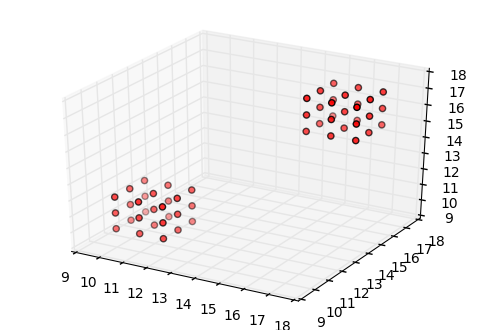

In [2]:
#The two cluster data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = twoClusterDat.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

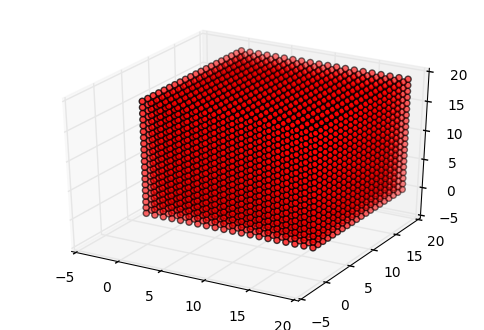

In [3]:
#The uniform data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = all100Dat.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

In [4]:
#Get the implemented library code
import plosLib as pLib
import connectLib as cLib

In [7]:
twoClusterResults = pLib.pipeline(twoClusterDat)
bianTwoClusterResults = cLib.otsuVox(twoClusterResults)

### 2.Generate Initial Results

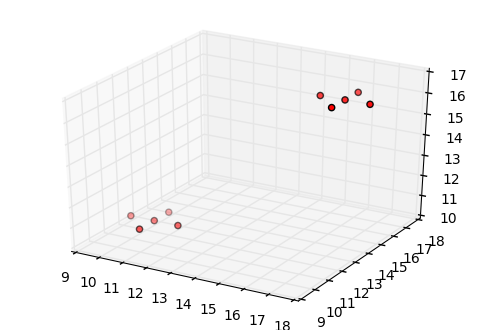

In [8]:
#The binary two cluster results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = bianTwoClusterResults.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

In [9]:
uniformResults = pLib.pipeline(all100Dat)
bianUniformResults = cLib.otsuVox(uniformResults)

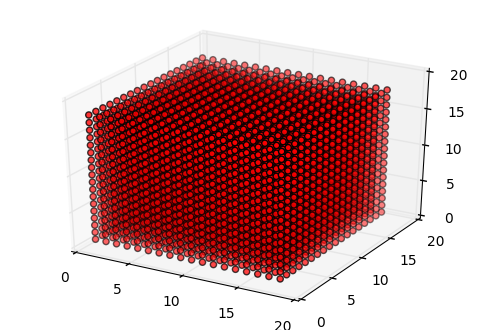

In [11]:
#The binary two cluster results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = uniformResults.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

### 3. Analyze Initial Results

The results above are consistent with the provided hypothesis. The algorithm performed well on the well separated, highly variant data, and poorly on the non-separated, invariant data. 

### 4. Validation Testing
#### Success
The following code will randomly populate a 100x100x100 cube with between 1 and 10 non-overlapping 3x3 synapses, as well as up to 30 'noise' pixels. It will then score the binarized pipeline output in the following way:
1. Probability of Detection (PD) will be calculated based on how many true synapse points the algorithm detects after the binarization step. A synapse is deteted if any point in its volume is given a score of 1 post-binarization

2. False Alarm Rate (FAR) will be calculated based on how many points are scored with a 1, post-binarization, that do not correspond with any point in the volume of a cluster

In [ ]:
import random.randrange as rand
from skimage.measure import label
from sets import Set

def generatePointSet():
    center = (rand(0, 100), rand(0, 100), rand(0, 100))
    toPopulate = []
    for z in (-1, 0, 1):
        for y in range(-1, 0, 1):
            for x in range(-1, 0, 1):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)               
                #only populate valid points
                for dim in range(3):
                    if curPoint[dim] >= 0 and curPoint[dim] <= 100:
                        toPopulate.append(curPoint)
    return Set(toPopulate)                       

                    
def generateTestVolume():
    #create a test volume
    volume = np.zeros((100, 100, 100))
    myPointSet = []
    for _ in range(rand(0, 11)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = 100
        
    #introduce noise
    noiseVolume = np.copy(volume)
    for _ in range(rand(0, 31)):
        noiseVolume[rand(0, 100)][rand(0, 100), rand(0, 100)
        

def executeTest():
    trueVolume, testVolume = generateTestVolume()
    
    results = cLib.otsuVox(pLib.pipeline(volume))
    